In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)


TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [0]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

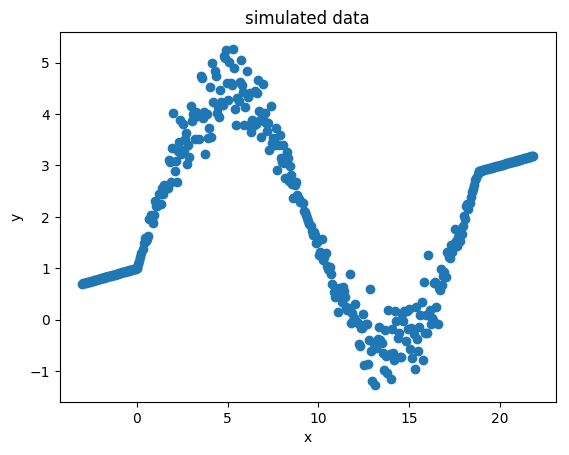

In [4]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## TFP aleatoric

In [0]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_aleatoric = Model(inputs=inputs, outputs=dist)
model_aleatoric.compile(Adam(), loss=NLL) 

In [6]:
model_aleatoric.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
___________________________________________________________

In [0]:
history = model_aleatoric.fit(x, y, epochs=3000, verbose=0,batch_size=32)

In [0]:
model_aleatoric_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_sd = Model(inputs=inputs, outputs=dist.stddev())

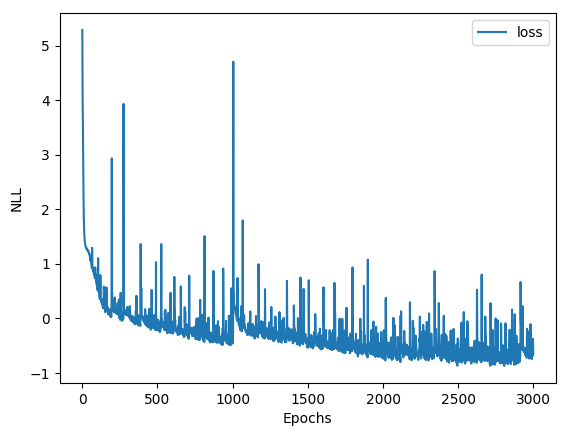

In [9]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

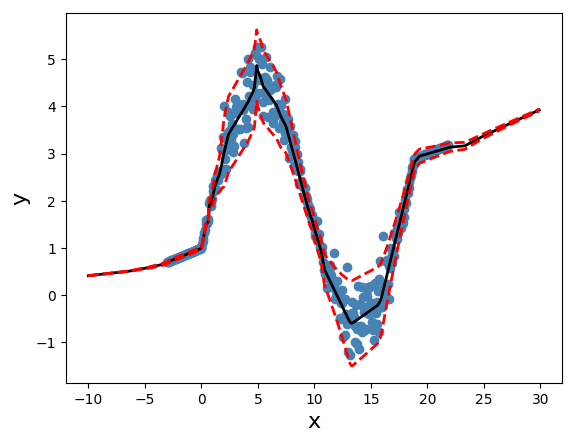

In [10]:

x_pred = np.arange(-10,30,0.1)

plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()


## TFP aleatoric and epistemic

In [0]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 


model_aleatoic_epistemic = Model(inputs=inputs, outputs=dist)
model_aleatoic_epistemic.compile(Adam(), loss=NLL) 

In [12]:
model_aleatoic_epistemic.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 20)                80        
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [13]:
import timeit
start = timeit.timeit()
history = model_aleatoic_epistemic.fit(x, y, epochs=15000, verbose=0,batch_size=32)
end = timeit.timeit()
print(end - start)
#model save and load otherwise needs a lot of time...
# around 10 min

-0.008456848000037098


In [0]:
#model_aleatoic_epistemic.save('model_aleatoic_epistemic.hdf5')  # save model


In [0]:
#import urllib.request
#url = 'https://github.com/tensorchiefs/dl_book/blob/master/data/model_aleatoic_epistemic.h5'
#urllib.request.urlretrieve(url, 'test.hdf5')

In [0]:
#!ls

In [0]:
#!dir

In [0]:
#from tensorflow.keras.models import load_model
#import h5py

#model_aleatoic_epistemic = load_model('model_aleatoic_epistemic.h5')

In [0]:
model_aleatoric_epistemic_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_epistemic_sd = Model(inputs=inputs, outputs=dist.stddev())

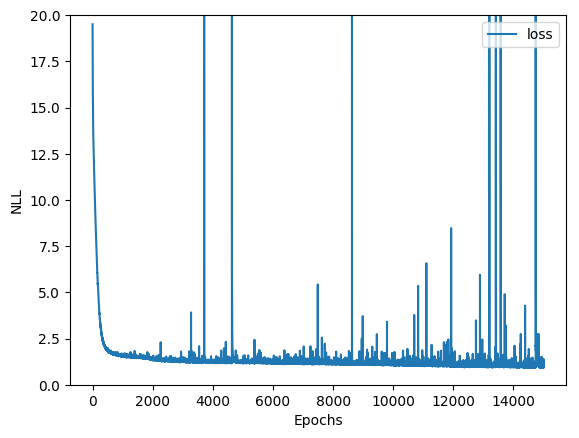

In [19]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim([0,20])
plt.show()

In [20]:
min(history.history['loss'])

0.9048898918288094

In [21]:
model_aleatoric_epistemic_mean.predict(x_pred[0:1])

array([[-13.442874]], dtype=float32)

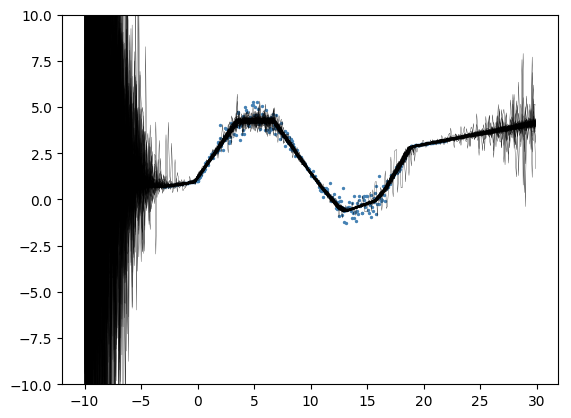

In [26]:
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,100):
  plt.plot(x_pred,np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred)),color="black",linewidth=0.2)
  plt.ylim([-10,10])


In [23]:
x_pred = np.arange(-10,30,0.1)
n=1000
n_preds_vi=np.zeros((n,len(x_pred)))
n_preds_std_vi=np.zeros((n,len(x_pred)))

for i in tqdm(range(0,n)):
  n_preds_vi[i,:]=np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred))
  n_preds_std_vi[i,:]=np.reshape(model_aleatoric_epistemic_sd.predict(x_pred),len(x_pred))

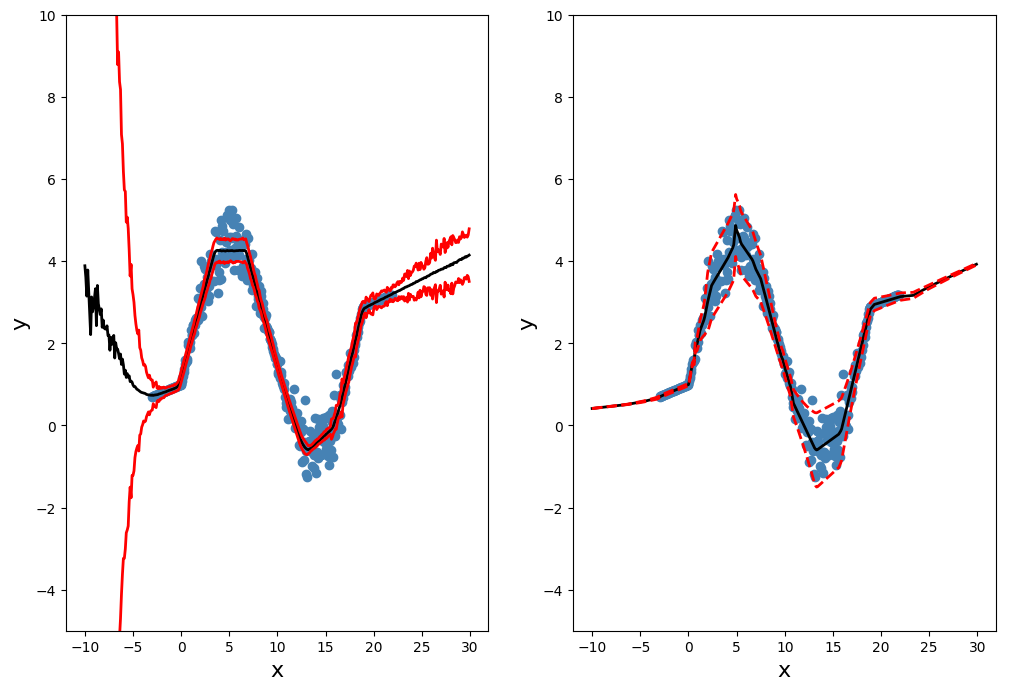

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_vi,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)+2*np.std(n_preds_vi,axis=0),color="red",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)-2*np.std(n_preds_vi,axis=0),color="red",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.ylim([-5,10])


plt.subplot(1,2,2)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.ylim([-5,10])
plt.show()


## MC Dropout

In [0]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#we need to disable the eager execution to do multiple mc runs

In [0]:
# define loss function that corresponds to NLL  
import math
def my_NLL_loss(y_true,y_pred):
  mu=tf.slice(y_pred,[0,0],[-1,1])              # A     
  sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # B 
  
  a=1/(tf.sqrt(2.*math.pi)*sigma) 
  b1=tf.square(mu-y_true)
  b2=2*tf.square(sigma)
  b=b1/b2
  
  loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
  return loss

#A extract first column for μ 
#B extract second column for σ

In [0]:
#http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
out = Dense(2)(hidden)

model_mc = Model(inputs=inputs, outputs=out)
model_mc.compile(Adam(), loss=my_NLL_loss) 

In [30]:
model_mc.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               400       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               100500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0   

In [0]:
history = model_mc.fit(x, y, epochs=15000, verbose=0,batch_size=32)
#dauert ca 20min

Text(0.5, 0, 'Epochs')

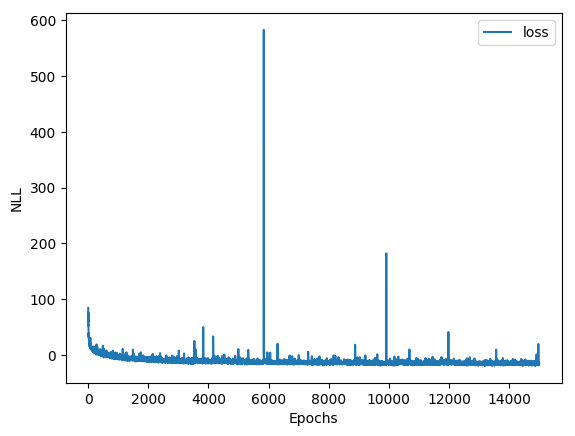

In [32]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [33]:
min(history.history['loss'])


-19.853262216704234

In [0]:
#import tensorflow.keras.backend as K
#model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])

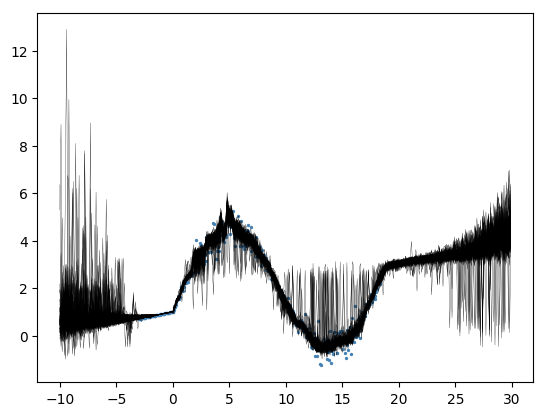

In [35]:
#deep 5 layer 1024 and low rate=0.1
plt.scatter(x,y,color="steelblue",s=2) #observerd 
for i in range(0,100):
  plt.plot(x_pred,model_mc.predict(x_pred)[:,0],color="black",linewidth=0.2)


In [36]:
n=1000
n_preds_mc=np.zeros((n,len(x_pred)))
n_preds_mc_std=np.zeros((n,len(x_pred)))
for i in tqdm(range(0,n)):
  n_preds_mc[i,:]=np.squeeze(model_mc.predict(x_pred)[:,0])
  n_preds_mc_std[i,:]=np.exp(np.squeeze(model_mc.predict(x_pred)[:,1]))

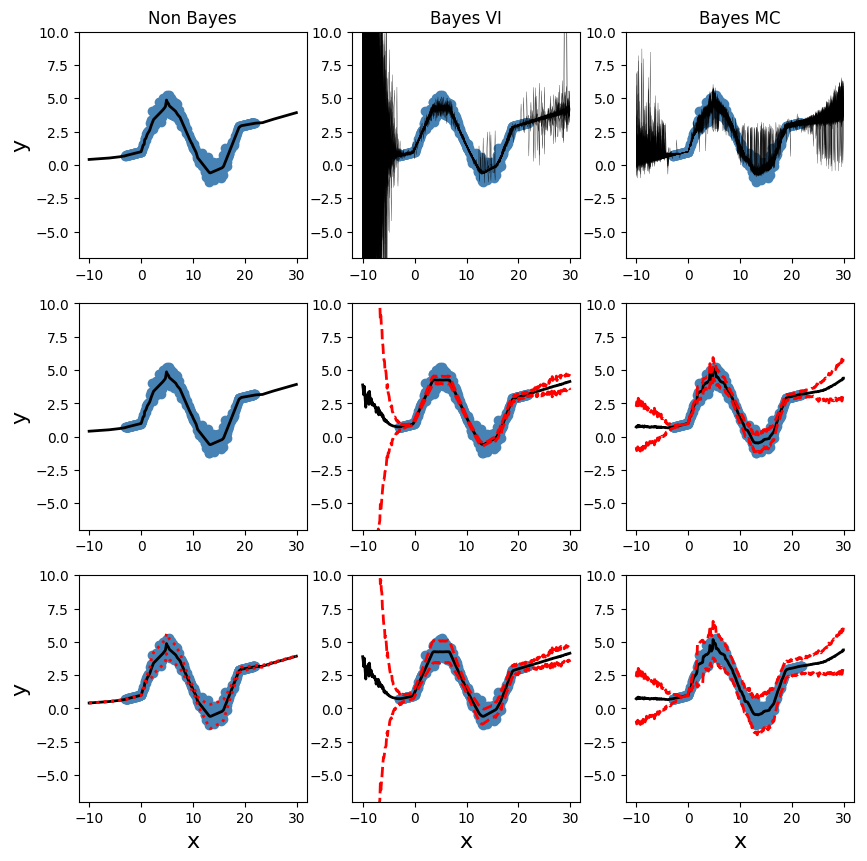

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.ylim([-7,10])
plt.title("Non Bayes")
plt.ylabel("y",fontsize=16)

plt.subplot(3,3,2)
plt.scatter(x,y,color="steelblue") #observerd 
for i in range(0,100):
  plt.plot(x_pred,np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred)),color="black",linewidth=0.2)
  plt.ylim([-7,10])
plt.title("Bayes VI")

plt.subplot(3,3,3)
plt.scatter(x,y,color="steelblue") #observerd 
for i in range(0,100):
  plt.plot(x_pred,model_mc.predict(x_pred)[:,0],color="black",linewidth=0.2)
  plt.ylim([-7,10])
plt.title("Bayes MC")

plt.subplot(3,3,4) 
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.ylim([-7,10])
plt.ylabel("y",fontsize=16)



plt.subplot(3,3,5)  
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_vi,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)+2*np.std(n_preds_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)-2*np.std(n_preds_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])

plt.subplot(3,3,6)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_mc,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)+2*np.std(n_preds_mc,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)-2*np.std(n_preds_mc,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])

plt.subplot(3,3,7)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle=":",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle=":",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.subplot(3,3,8)  
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_vi,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)+2*np.std(n_preds_vi,axis=0)+np.mean(n_preds_std_vi,axis=0)+2*+np.std(n_preds_std_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)-2*np.std(n_preds_vi,axis=0)-np.mean(n_preds_std_vi,axis=0)-2*+np.std(n_preds_std_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)

plt.subplot(3,3,9)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_mc,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)+2*np.std(n_preds_mc,axis=0)+np.mean(n_preds_mc_std,axis=0)+2*+np.std(n_preds_mc_std,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)-2*np.std(n_preds_mc,axis=0)-np.mean(n_preds_mc_std,axis=0)-2*+np.std(n_preds_mc_std,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)
plt.show()